In [2]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/urban-form-ml/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

## Preprocessing

In [5]:
path_data_netherlands_fts = os.path.join('..', 'data', 'netherlands_cities_0_200_fts.csv')
path_data_netherlands_attr = os.path.join('..', 'data', 'outdated', 'netherlands-gov_attrib.csv')
data_netherlands_fts = pd.read_csv(path_data_netherlands_fts)
data_netherlands_attr = pd.read_csv(path_data_netherlands_attr)

In [19]:
path_data_netherlands_cvg = os.path.join('..', 'data', 'ua_matching.csv')
data_netherlands_cvg = pd.read_csv(path_data_netherlands_cvg)


In [6]:
data_netherlands_fts = data_netherlands_fts.drop_duplicates(subset=['id'])
data_netherlands_attr = data_netherlands_attr.drop_duplicates(subset=['id'])

In [7]:
data_netherlands_ua = pd.concat([data_netherlands_fts.set_index('id'), data_netherlands_attr.set_index('id')], axis=1, join="inner").reset_index()

In [32]:
# print(len(data_netherlands))
# print(data_netherlands.columns)
# print(data_netherlands_attr.columns)
# data_netherlands['age_wsf']

3137276
Index(['id', 'age_wsf', 'bld_in_lu_agricultural',
       'bld_in_lu_industrial_commercial', 'bld_in_lu_natural',
       'bld_in_lu_other', 'bld_in_lu_roads', 'bld_in_lu_urban_fabric',
       'bld_in_lu_urban_green', 'bld_in_lu_water', 'bld_in_lu_ocean_country',
       'bld_in_lu_railways', 'bld_in_lu_ports_airports',
       'lu_ocean_country_within_buffer_100', 'lu_natural_within_buffer_100',
       'lu_industrial_commercial_within_buffer_100',
       'lu_other_within_buffer_100', 'lu_water_within_buffer_100',
       'lu_urban_green_within_buffer_100', 'lu_agricultural_within_buffer_100',
       'lu_railways_within_buffer_100', 'lu_urban_fabric_within_buffer_100',
       'lu_ports_airports_within_buffer_100', 'lu_roads_within_buffer_100',
       'lu_ocean_country_within_buffer_500', 'lu_natural_within_buffer_500',
       'lu_industrial_commercial_within_buffer_500',
       'lu_other_within_buffer_500', 'lu_water_within_buffer_500',
       'lu_urban_green_within_buffer_500', 'lu

0             NaN
1             NaN
2          1985.0
3          1985.0
4             NaN
            ...  
3137271    1985.0
3137272    1985.0
3137273    1993.0
3137274    1985.0
3137275    1985.0
Name: age_wsf, Length: 3137276, dtype: float64

In [35]:
path_data_netherlands_ua = os.path.join('..', 'data', 'netherlands-cities-200-ua-wsf.csv')
data_netherlands_ua.to_csv(path_data_netherlands_ua, encoding='utf-8', index=False)


## Data

In [36]:
data_netherlands_ua = pd.read_csv(path_data_netherlands_ua)

In [ ]:
path_data_netherlands_rest = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands_rest = pd.read_csv(path_data_netherlands_rest)

In [64]:
data_netherlands = pd.concat([data_netherlands_rest.set_index('id'), data_netherlands_ua.set_index('id')], axis=1, join="inner").reset_index()
data_netherlands = data_netherlands.loc[:,~data_netherlands.columns.duplicated()]


NameError: name 'data_netherlands_rest' is not defined

In [65]:
data_netherlands = data_netherlands.loc[:,~data_netherlands.columns.duplicated()]


In [68]:
data_netherlands_sample = data_netherlands.sample(frac=.1)

In [75]:
list(data_netherlands_sample.columns)
# import collections
# print([item for item, count in collections.Counter(list(data_netherlands_sample.columns)).items() if count > 1])




['id',
 'FootprintArea',
 'Perimeter',
 'Phi',
 'LongestAxisLength',
 'Elongation',
 'Convexity',
 'Orientation',
 'Corners',
 'CountTouches',
 'SharedWallLength',
 'lat',
 'lon',
 'buildings_within_buffer_100',
 'total_ft_area_within_buffer_100',
 'av_footprint_area_within_buffer_100',
 'av_elongation_within_buffer_100',
 'av_convexity_within_buffer_100',
 'av_orientation_within_buffer_100',
 'std_footprint_area_within_buffer_100',
 'std_elongation_within_buffer_100',
 'std_convexity_within_buffer_100',
 'std_orientation_within_buffer_100',
 'buildings_within_buffer_500',
 'total_ft_area_within_buffer_500',
 'av_footprint_area_within_buffer_500',
 'av_elongation_within_buffer_500',
 'av_convexity_within_buffer_500',
 'av_orientation_within_buffer_500',
 'std_footprint_area_within_buffer_500',
 'std_elongation_within_buffer_500',
 'std_convexity_within_buffer_500',
 'std_orientation_within_buffer_500',
 'TouchesIndexes',
 'BlockLength',
 'AvBlockFootprintArea',
 'StdBlockFootprintArea'

In [52]:
len(data_netherlands.drop_duplicates(subset=['id']))


1254060

## Experiments

2022-01-26 09:16:47,589 | INFO : Dataset length: 125406
2022-01-26 09:16:47,712 | INFO : Test dataset length: 25082
2022-01-26 09:16:47,712 | INFO : Training dataset length: 100324
2022-01-26 09:16:47,713 | INFO : Standard deviation of test set: 33.07168145093949
2022-01-26 09:16:47,715 | INFO : Mean age of test set: 1973.828522446376
2022-01-26 09:16:47,905 | INFO : Test dataset length after preprocessing: 24322
2022-01-26 09:16:47,905 | INFO : Training dataset length after preprocessing: 97431
2022-01-26 09:16:47,907 | INFO : Standard deviation of test set after preprocessing: 24.666570357495733
2022-01-26 09:16:47,908 | INFO : Mean age of test set after preprocessing: 1977.244099991777


MAE: 12.015112984250049 y
RMSE: 17.90891128878359 y
R2: 0.4728445654260016


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


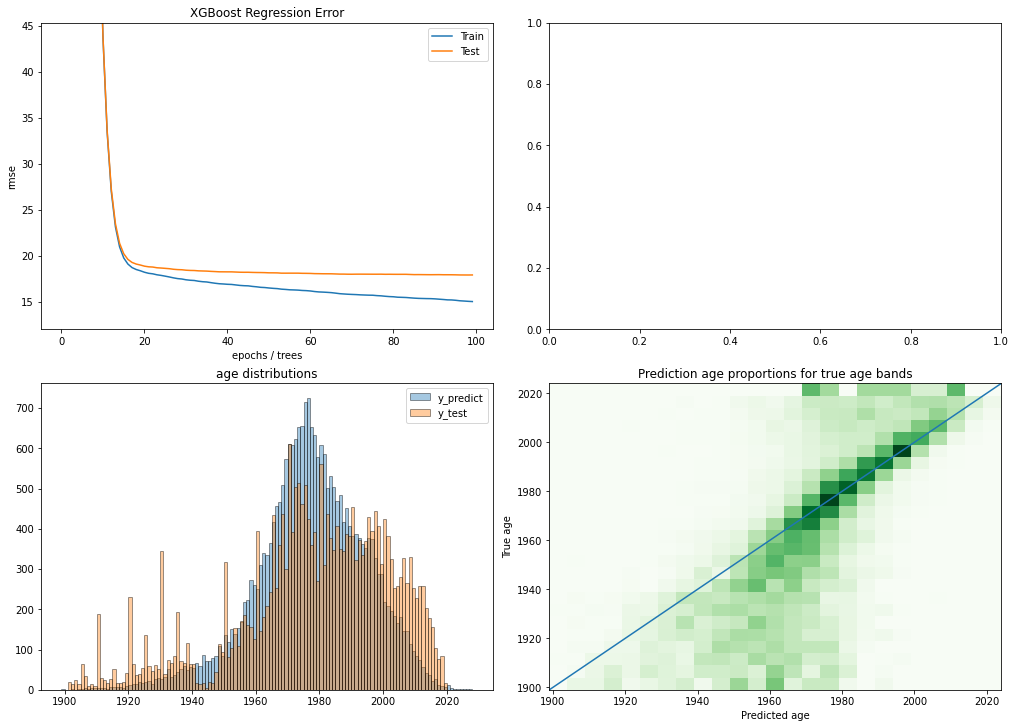

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

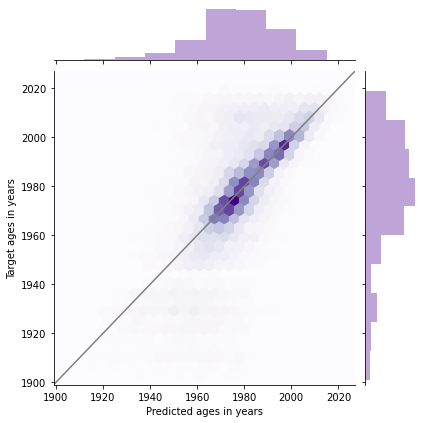

In [71]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)
predictor.evaluate_regression()

2022-01-26 10:29:17,173 | INFO : Dataset length: 125406
2022-01-26 10:29:17,364 | INFO : Test dataset length: 25082
2022-01-26 10:29:17,365 | INFO : Training dataset length: 100324
2022-01-26 10:29:17,366 | INFO : Standard deviation of test set: 33.07168145093949
2022-01-26 10:29:17,368 | INFO : Mean age of test set: 1973.828522446376
2022-01-26 10:29:17,572 | INFO : Test dataset length after preprocessing: 24322
2022-01-26 10:29:17,572 | INFO : Training dataset length after preprocessing: 97431
2022-01-26 10:29:17,573 | INFO : Standard deviation of test set after preprocessing: 24.666570357495733
2022-01-26 10:29:17,574 | INFO : Mean age of test set after preprocessing: 1977.244099991777


MAE: 12.562032522197303 y
RMSE: 18.18452176172456 y
R2: 0.45649432187297445


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
invalid value encountered in true_divide


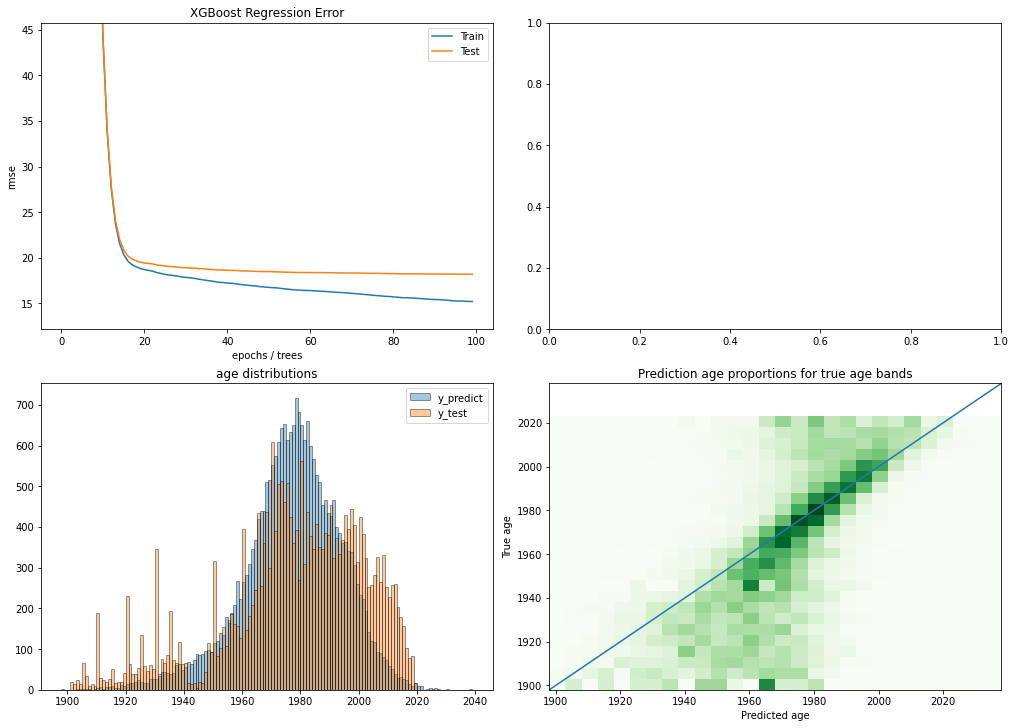

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

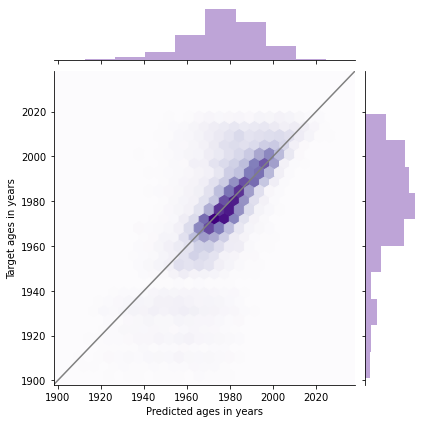

In [123]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)
predictor.evaluate_regression()

2022-01-26 11:00:20,867 | INFO : Dataset length: 125406
2022-01-26 11:00:21,028 | INFO : Test dataset length: 25082
2022-01-26 11:00:21,029 | INFO : Training dataset length: 100324
2022-01-26 11:00:21,030 | INFO : Standard deviation of test set: 33.07168145093949
2022-01-26 11:00:21,031 | INFO : Mean age of test set: 1973.828522446376
2022-01-26 11:00:21,307 | INFO : Test dataset length after preprocessing: 24322
2022-01-26 11:00:21,307 | INFO : Training dataset length after preprocessing: 97431
2022-01-26 11:00:21,309 | INFO : Standard deviation of test set after preprocessing: 24.666570357495733
2022-01-26 11:00:21,310 | INFO : Mean age of test set after preprocessing: 1977.244099991777


MAE: 11.9678370925355 y
RMSE: 17.874770415874487 y
R2: 0.47485254809821953


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
invalid value encountered in true_divide


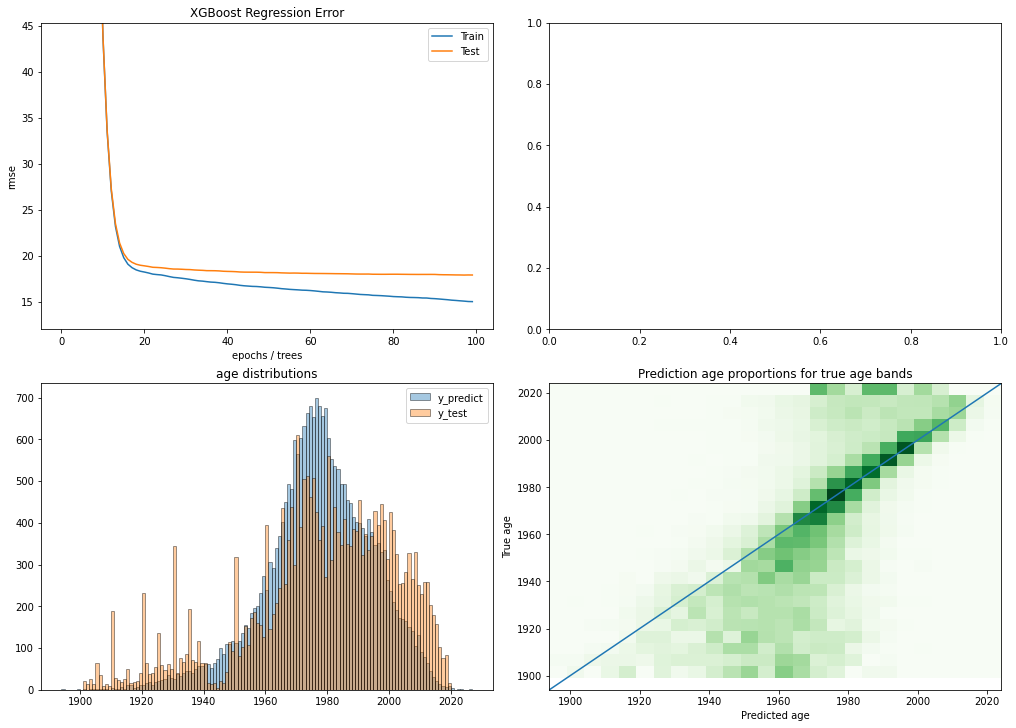

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

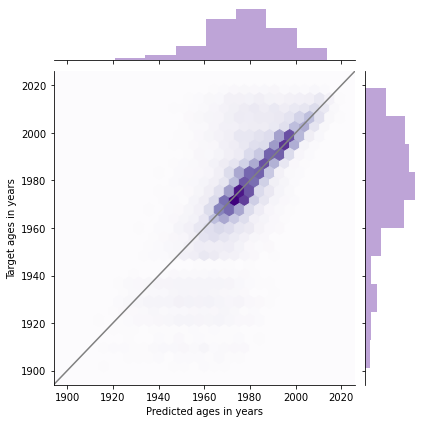

In [125]:
data_netherlands_sample_old_features = data_netherlands_sample[data_netherlands_sample.columns.drop(list(data_netherlands_sample.filter(regex='lu_')))]

predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sample_old_features,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)
predictor.evaluate_regression()

All metrics only for buildings after 1985 (according to WSF data):
RMSE: 15.28 y
RMSE after postprocessing: 15.56 y
RMSE for WSF: 20.42 y
R2: 0.3763
R2 after postprocessing: 0.3530
R2 for WSF: -0.1143


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


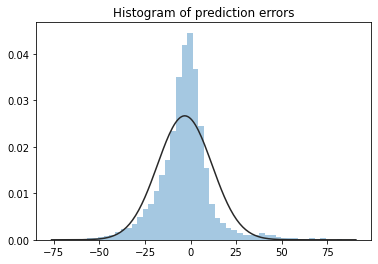

Excess kurtosis of normal distribution (should be 0): 4.243019763322954
Skewness of normal distribution (should be 0): 0.5717742164527655


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


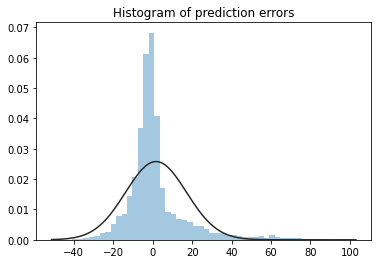

Excess kurtosis of normal distribution (should be 0): 6.18408417812026
Skewness of normal distribution (should be 0): 2.011715123999469


In [119]:
from sklearn import metrics

def postprocess_wsf(predict_df, wsf_df, test_df, exclude_wsf_old_buildings=True):
    postprocessed_df = pd.DataFrame()
    postprocessed_df['age_predict'] = predict_df[dataset.AGE_ATTRIBUTE]
    postprocessed_df['age_test'] = test_df[dataset.AGE_ATTRIBUTE]
    postprocessed_df['age_wsf'] =  wsf_df['age_wsf']

    if exclude_wsf_old_buildings:
        postprocessed_df = postprocessed_df[postprocessed_df['age_wsf'] > 1985]

    postprocessed_df['age_postprocessed'] = postprocessed_df[['age_wsf', 'age_predict']].mean(axis=1)

    print('All metrics only for buildings after 1985 (according to WSF data):')
    print('RMSE: {0:.2f} y'.format(np.sqrt(metrics.mean_squared_error(postprocessed_df['age_test'], postprocessed_df['age_predict']))))
    print('RMSE after postprocessing: {0:.2f} y'.format(np.sqrt(metrics.mean_squared_error(postprocessed_df['age_test'], postprocessed_df['age_postprocessed']))))
    print('RMSE for WSF: {0:.2f} y'.format(np.sqrt(metrics.mean_squared_error(postprocessed_df['age_test'], postprocessed_df['age_wsf']))))

    print('R2: {0:.4f}'.format(metrics.r2_score(postprocessed_df['age_test'], postprocessed_df['age_predict'])))
    print('R2 after postprocessing: {0:.4f}'.format(metrics.r2_score(postprocessed_df['age_test'], postprocessed_df['age_postprocessed'])))
    print('R2 for WSF: {0:.4f}'.format(metrics.r2_score(postprocessed_df['age_test'], postprocessed_df['age_wsf'])))
    return postprocessed_df

postprocessed_df = postprocess_wsf(predictor.y_predict, predictor.aux_vars_test, predictor.y_test)
visualizations.plot_prediction_error_histogram(postprocessed_df['age_test'], postprocessed_df['age_predict'])
visualizations.plot_prediction_error_histogram(postprocessed_df['age_test'], postprocessed_df['age_postprocessed'])



In [127]:
list(data_netherlands_sample.columns)

['id',
 'FootprintArea',
 'Perimeter',
 'Phi',
 'LongestAxisLength',
 'Elongation',
 'Convexity',
 'Orientation',
 'Corners',
 'CountTouches',
 'SharedWallLength',
 'lat',
 'lon',
 'buildings_within_buffer_100',
 'total_ft_area_within_buffer_100',
 'av_footprint_area_within_buffer_100',
 'av_elongation_within_buffer_100',
 'av_convexity_within_buffer_100',
 'av_orientation_within_buffer_100',
 'std_footprint_area_within_buffer_100',
 'std_elongation_within_buffer_100',
 'std_convexity_within_buffer_100',
 'std_orientation_within_buffer_100',
 'buildings_within_buffer_500',
 'total_ft_area_within_buffer_500',
 'av_footprint_area_within_buffer_500',
 'av_elongation_within_buffer_500',
 'av_convexity_within_buffer_500',
 'av_orientation_within_buffer_500',
 'std_footprint_area_within_buffer_500',
 'std_elongation_within_buffer_500',
 'std_convexity_within_buffer_500',
 'std_orientation_within_buffer_500',
 'TouchesIndexes',
 'BlockLength',
 'AvBlockFootprintArea',
 'StdBlockFootprintArea'